In [1]:
# Package Imports:

import config # Load WIPLEX configuration
import geopandas as gpd
import numpy as np
import pandas as pd 
import pickle
import glob
import os
import pulp as plp #package used to solve Mixed Integer Programming Problem # https://pyomo-simplemodel.readthedoc
import time
from pathlib import Path
import itertools
from multiprocessing import Pool, freeze_support, Manager
from itertools import repeat
import ast
import signal
import math


In [2]:
#############################################################################################################
################################################ Function Hub ###############################################


# ----------------------------------------- Additional helper Functions ------------------------------------------ #

def up_down_round(x, base=50, up=True):
    if up:
        return base * math.ceil(x/base)
    else:
        return base * math.floor(x/base)



def interpolate_heights(wpc_array, t_height, gwa_heights = [50, 100, 150, 200]):
    lower_layer = up_down_round(t_height, up=False)
    upper_layer = up_down_round(t_height, up=True)
    lower_index = gwa_heights.index(lower_layer)
    upper_index = gwa_heights.index(upper_layer)

    return wpc_array[:,lower_index] + (wpc_array[:,upper_index] - wpc_array[:,lower_index]) * (t_height - lower_layer)/50

# ----------------------------------------- Wind power functions ------------------------------------------ #

def weibull_wind_pdf(x, k, A):
    return k/A * (x/A)**(k-1) * np.exp(-(x/A)**k)


def wind_power_function(ws, radius, ad, cp):
    # Calculating costs using wind power function
    return (np.pi/2) * ws**3 * radius**2 * ad * cp * 1e-6


def weibull_power_output(gdf, gwa_heights, cp_df, types_df):
    x = np.arange(3, 26, 1)
    wb_A = gdf[[f"wb_A_{x}" for x in gwa_heights]].to_numpy()
    wb_k = gdf[[f"wb_k_{x}" for x in gwa_heights]].to_numpy()
    ad_array = gdf[[f"ad_{x}" for x in gwa_heights]].to_numpy()
    blade_radius = types_df["Rotor diameter (m)"].to_numpy()/2
    
    array_list = []
    for ws in x:
        probs = weibull_wind_pdf(ws, wb_k, wb_A)
        cp_array = cp_df[cp_df["Wind Speed"] == ws].loc[:,cp_df.columns != 'Wind Speed'].to_numpy()
        res_wp = wind_power_function(ws, blade_radius, ad_array, cp_array) 
        res_clipped = np.clip(res_wp, a_min=0, a_max=types_df["Rated power (MW)"].values) # clip results to not exceed rated power
        res_out = res_clipped * probs # multiply with weibull probability
        array_list.append(res_out)
    return np.array(array_list)


# ----------------------------------------- Location Cost Functions ------------------------------------------ #

def aggregate_property_values(gdf, impact_range):
    '''
    Function calulates the aggregate property value of buildings in each impact zone for all cells in the gdf.
    Parameters
    ----------
        gdf :  geopandas.GeoDataFrame
            GeoDataFrame containing house price and property impact information (columns: eg: imp_500m,..., hp )
        impact_range : list
            list of integers specifying which impact ranges to use for the analysis
    Returns:
    --------
        impacts_hp : numpy.array
            Array containing aggregate property values for each cell and impact zone (cell x zone)
    '''
    # Define impact matrix
    imp_list = [f"imp_{i}" for i in impact_range]
    impacts = gdf.loc[:, imp_list].to_numpy()
    
    # Calculate aggregate  property values per impact zone:
    impacts_hp = impacts * gdf["hp"].to_numpy().reshape(-1, 1)
    
    return impacts_hp

def calculate_location_costs(gdf, damage_df, t_types_df, impact_range, externality=True):
    '''
    Function for calculating location specific costs for each of the turbines in the dataset
    
    Parameters
    ----------
    gdf : geopandas.GeoDataFrame
        GeoDataFrame containing the all location information (placement locations, impacts, house prices...)
    damage_df: pandas.DataFrame
        DataFrame with the damage assumptions for each turbine (turbines as collumns and impact zones as rows)
    t_type_df: pandas.DataFrame
        DataFrame with information on each turbine used (name, height, rated power, ...)
    impact_range: list
        List containing all impact zones that should be used (maximum is the max number of impacts calculated)
    externality: Bolean
        Parameter indicating if wind power externalities should be considered (Default=True)

    Returns
    -------
        total_cost, ext_cost, const_cost: np.arrays
            Arrays containing information on total, externality and construction costs for each location and turbine
    '''
    # Definition of property damage matrix:
    damage_selection = damage_df.loc[damage_df["Upper"].isin(impact_range)]
    prop_damages = damage_selection[list(t_types_df["Name"])].to_numpy()

    # Obtain house price values for each location
    prop_values = aggregate_property_values(gdf, impact_range)/1000000
    
    # Caclulation of externalities:
    if not externality:
        ext_cost = np.zeros((len(gdf), len(t_types)))
    else:
        ext_cost = np.round(prop_values @ prop_damages, 2)

    # Calculation of construction costs:
    const_cost = t_types["Total construction cost (million €)"].to_numpy().reshape(1,-1)

    # Calc total costs:
    total_cost = ext_cost + const_cost
    
    return total_cost, ext_cost, const_cost

# ----------------------------------------- Optimization Functions ------------------------------------------ #

def minimization_problem(total_cost, wpc, expansion_goal):
    '''
    Main optimization function of the Wind turbine placement algorithm

    Parameters
    ----------
    total_cost : np.array
        Array containing the total cost (project + externality cost) for each wind turbine
        and placement location.
    wpc : np.array
        Array containing the wind power capacity values for each turbine and location.
    expansion_goal : int
        Value representing the expansion goal (in MW).

    Returns
    -------
    turbines_opt : np.arrays
        Array containing Bolean values (0,1) for each turbine and location. It indicates
        which turbine is built in which location (array element=1)

    '''
    # Create model
    m = plp.LpProblem("TC_Germany", plp.LpMinimize)


    # Choice Variables:
    t_list = []
    for i in range(total_cost.shape[1]):
        turbine = plp.LpVariable.dicts(f't{i}', range(len(total_cost)) , lowBound=0, upBound=1, cat=plp.LpBinary)
        t_list.append(list(turbine.values()))
    
    #turbines = np.array([list(turbines_100.values()), list(turbines_150.values())]).T
    turbines = np.array(t_list).T

    # # Objective
    #print('Setting up Objective Function...')
    m += plp.lpSum(total_cost * turbines)

    # Constraint
    #print('Adding constraints...')
    m += plp.lpSum(wpc * turbines) >= expansion_goal, "Expansion Constraint"

    for i in range(len(turbines)):
        m += plp.lpSum(turbines[i,:]) <= 1, f"Site constraint {i}"


    # Define the solver:
    if "GUROBI_CMD" in plp.listSolvers(onlyAvailable=True):  
        solver = plp.GUROBI_CMD(msg=0, options=[("MIPGap", 1e-3)])
    else:
        #solver = plp.PULP_CBC_CMD(msg=0)
        solver = plp.GLPK_CMD(path='C:\\Program Files\\glpk-4.65\\w64\\glpsol.exe', msg=0, options = ["--mipgap", "0.01"])  #,"--tmlim", "2000"
    # use other solver: plp.PULP_CBC_CMD(msg=0) ; plp.GLPK_CMD(path='C:\\Program Files\\glpk-4.65\\w64\\glpsol.exe', msg=0, options = ["--mipgap", "0.001","--tmlim", "1000"])


    # Optimize
    #print('Started optimization')
    m.solve(solver)


    # Print the status of the solved LP
    print(f"Status = {plp.LpStatus[m.status]}")

    # Print the value of the objective
    print(f"Objective value = {plp.value(m.objective)}")

    # Print the value of the constraint:
    sel = []
    for constraint in m.constraints:
        if constraint == "Expansion_Constraint":
            constraint_sum = 0
            for var, coefficient in m.constraints[constraint].items():
                constraint_sum += var.varValue * coefficient
                sel.append(var.varValue)
            print(m.constraints[constraint].name, constraint_sum)
        else:
            pass
    
    turbine_opt_list = []
    for turbine_type in t_list:
        turbine_results = [t.varValue for t in turbine_type]
        turbine_opt_list.append(turbine_results)
            
    turbines_opt = np.array(turbine_opt_list).T
    
    return turbines_opt


def run_optimization(expansion_goal, tot_cost_array, wpc_array, storage_dict):
    print(f'Started optimization for expansion goal {expansion_goal}')
    if expansion_goal in storage_dict.keys():
        print(f"Expansion goal {expansion_goal}MW already calculated! Proceeding... ")
    else:
        start = time.time()
        storage_dict[expansion_goal] = minimization_problem(tot_cost_array, wpc_array, expansion_goal)
        print(f'Finished optimization for expansion goal {expansion_goal}m!...solving time:', time.time() - start)


def optimization_loop(gdf, damage_df, t_type_df, cp_df, impact_range, scenario, gwa_heights, 
                      overwrite, expansion_goals, out_dir, multiprocessing=False):
    '''
    Main optimization loop to evaluate different expansion scenarios.

    Parameters
    ----------
    gdf : geopandas.GeoDataFrame
        GeoDataFrame containing the all information (placement locations, impacts, house prices...)
    damage_df: pandas.DataFrame
        DataFrame with the damage assumptions for each turbine (turbines as collumns and impact zones as rows)
    t_type_df: pandas.DataFrame
        DataFrame with information on each turbine used (name, height, rated power, ...)
    impact_range: list
        List containing all impact zones that should be used (maximum is the max number of impacts calculated)
    scenario: string
        Name of the Scenario that should be used. This should be identical to the sheet name of the damage scenario in the assumptions file
    gwa_heights: list
        list of integers specifying which wind layers (height) of the Global wind Atlas should be used
    overwrite : Bolean
        Bolean value that defines whether new expansion scenarios should just be added to an existing file or if old 
        scenarios should be overwritten.
    expansion_goals : list
        List of of integer values defining the expansion scenarios for which to run the optimization.
    out_dir : string
        Directory where the output files should be saved to.

    Returns
    -------
    None.

    '''
    print("Started optimization process...")
  
    # Calculate Wind Power Capacity
    wpc = weibull_power_output(gdf, gwa_heights, cp_df, t_type_df).sum(axis=0)

    # Interpolate power Outputs using turbine height:
    wpc = np.vstack([interpolate_heights(wpc, t_height) for t_height in list(t_type_df["Hub height (m)"])]).T

    # Calculate Location Specific Costs:
    total_lsc, ext_lsc, const_lsc = calculate_location_costs(gdf, damage_df, t_type_df, impact_range, 
                                                             externality=True)

    
    if os.path.isfile(f'{out_dir}_{scenario}.pickle') and not overwrite:
        with open(f'{out_dir}_{scenario}.pickle', "rb") as input_file:
            supply_fct = pickle.load(input_file)
    else:
        supply_fct = {}
    

    if multiprocessing:
        manager = Manager()
        supply_fct = manager.dict(supply_fct)

        p = Pool()                                   # Create a multiprocessing Pool
        p.starmap(run_optimization, zip(expansion_goals, repeat(total_lsc), repeat(wpc), repeat(supply_fct)))
        p.close()
        p.join()

    else:
        for i in expansion_goals:
            run_optimization(i, total_lsc, wpc, supply_fct)

    # Pickle results:
    supply_fct = dict(sorted(supply_fct.items(), key=lambda item: item[0])) # sort keys
    print(f'Saving to file: {out_dir}_{scenario}.pickle')
    with open(f'{out_dir}_{scenario}.pickle', 'wb') as handle:
        pickle.dump(supply_fct, handle, protocol=pickle.HIGHEST_PROTOCOL)


# ------------------------------------------ Output Functions -------------------------------------------- #

def calc_cost(turbines, total_cost, external_cost, const_cost):
    '''
    Function calculating total, external project and marginal cost 
    as well as the externality cost share for an array of selected turbines.
    '''
    marginal_cost = np.max(np.sum(total_cost * turbines, axis=1))
    p_cost = np.sum(const_cost * turbines) 
    ex_cost = np.sum(external_cost * turbines) 
    cost_total = p_cost + ex_cost
    ext_share = ex_cost/cost_total

    
    return [cost_total, ex_cost, p_cost, marginal_cost, ext_share]

def calc_other(turbines, expansion_goal, rated_power_array):
    '''
    Function calculates the aggregate rated power, average FLH and the  number of turbines
    build for each type for a given array of selected trubines
    '''
    turbine_count = np.sum(turbines, axis=0)
    rated_power_agg = np.sum(turbine_count *rated_power_array)
    flh = expansion_goal/rated_power_agg *8760

    return [rated_power_agg, flh] + list(turbine_count)

def generate_results_df(geo_df, model, damage_df, t_type_df, impact_range, ext=True):
    '''
    Function calculates the cost predictions for each expansion scenario of a given model using the optimization results.

    Parameters
    ----------
        geo_df : geopandas.GeoDataFrame
            Input DataFrame containing the cell data from the Global Wind Atlas for all valid placement cells
        model : dict
            Dictionary containing arrays with the optimization results (which cells are chosen and which turbine is built in a chosen cell)
        damage_df: pandas.DataFrame
            DataFrame with the damage assumptions for each turbine (turbines as collumns and impact zones as rows)
        t_type_df: pandas.DataFrame
            DataFrame with information on each turbine used (name, height, rated power, ...)
        impact_range: list
            List containing all impact zones that should be used (maximum is the max number of impacts calculated)
        ext: Bolean (default: True)
            Bolean indicating if externality cost should be considered or not. 

    Returns
    -------
        results_df : pandas.DataFrame
            Pandas DataFrame containing the cost predictions (total cost, externality cost, project cost and marginal cost)
            for each expansion scenario of the selected model

    '''
    # Calculate Location Specific Costs:
    total_lsc, ext_lsc, const_lsc = calculate_location_costs(geo_df, damage_df, t_type_df, impact_range, externality=True)
    
    results = []
    for i in list(model.keys()):
        results.append([i] + calc_other(model[i], i, np.array([t_type_df["Rated power (MW)"]])) + calc_cost(model[i], 
                                                                                                    total_lsc, ext_lsc, const_lsc))
    results_df = pd.DataFrame(results, columns=['Expansion Goal', 'Expansion Goal (rated)', 
                                                'FLH'] +  list(t_types.index) + ['Total Cost', 'Externality Cost', 
                                                'Project Cost', 'Marginal Cost', 'Ext. Share'])

    return results_df

def generate_optimization_output(gdf_in, opt_file_dir, damage_df,t_type_df, impact_range, out_file):
    '''
    Function calculates cost predictions for each file in a given opt_file_dir and generates a .xlsx table containing all cost predictions
    in this directory.

    Parameters
    ----------
        gdf_in: geopandas.GeoDataFrame
            DataFrame used for the optimization process
        damage_df: pandas.DataFrame
            DataFrame with the damage assumptions for each turbine (turbines as collumns and impact zones as rows)
        t_type_df: pandas.DataFrame
            DataFrame with information on each turbine used (name, height, rated power, ...)
        impact_range: list
            List containing all impact zones that should be used (maximum is the max number of impacts calculated)
        opt_file_dir: str
            String containing a path to the direcotory with the optimization results
        out_file: str
            Name of the output .xlsx file
    '''
    opt_files = glob.glob(f'{opt_file_dir}/*.pickle')

    df_list = []
    for file in opt_files:
        # Infer optimization settings from filename:
        filename_split = Path(file).stem.split('_')
        scenario = filename_split[-1]
        
        
        if scenario == "noext":
            externality = False
        else:
            externality = True
            
        # Load in optimized turbine location files:
        opt_result = pickle.load(open(file, "rb"))
        opt_result= dict(sorted(opt_result.items(), key=lambda item: item[0]))


        opt_df = generate_results_df(gdf_in, opt_result, damage_df, t_type_df, impact_range, ext=externality)
        opt_df['Scenario'] = scenario
        opt_df['Externality Cost (€/kW rated)'] = opt_df['Externality Cost'] / opt_df['Expansion Goal (rated)'] *1e-3
        opt_df['Project Cost (€/kW rated)'] = opt_df['Project Cost'] / opt_df['Expansion Goal (rated)'] *1e-3
        df_list.append(opt_df)

    df_out = pd.concat(df_list)
    df_out.to_excel(f'{out_file}.xlsx', index=False)


In [3]:
def power_scaling(wpc_in, flh_const=4000):
    '''
    Function is used to scale the wind power capacity array to a value 
    in line with a maximum FLH constraint of flh_const

    Parameters
    ----------
    wpc_in : np.array
        Numpy array containing the Wind power capacity values per turbine and location.
    flh_const: int
        Integer indicating the Maxiumum FLH constraint used for defining the scaling factor

    Returns
    -------
    wpc_out : np.array
        Array containing the scaled Wind power capacity values.

    '''
    # Scale Full load hours by the maxiumum FLH of the smaller turbine is 4000:
    flh_max = np.max(wpc_in[:, 0]) * 8760/3
    if flh_max > 4000:
        scaling = 4000/flh_max
    else:
        scaling = 1
    
    wpc_out = wpc_in * scaling
    
    return wpc_out

def sound_pressure_level(sound_power, distances, hub_height):
    '''
    Function that calculates the sound pressure level at several distances 
    depending on sound_ower and hub_height
    '''
    return sound_power - abs(10* np.log10(1/(4*np.pi* np.square(distances))))

def round_down(num, divisor):
    '''
    Function for rounding down a number (num) depening on a divisor.
    (Eg. With divisor 10 the number is rounded down to the nearest 10: 26-->20)
    '''
    return num - (num%divisor)

def sound_pressure_level_uj(sound_power, distances, hub_height):
    '''
    Function calculating the sound pressure level as defined in the paper 
    by Jensen et al. (2014)
    '''
    return sound_power - 10*np.log10(np.square(distances) + np.square(hub_height)) - 11 + 1.5 - (2/1000) * np.sqrt((np.square(distances) + np.square(hub_height)))

In [4]:
WIPLEX_config = config.WIPLEX_settings()
WIPLEX_config.initialize_config()
param = WIPLEX_config.param
paths = WIPLEX_config.paths

In [5]:
# Main geodataframe with Wind data, impacted buildings and house prices:
gdf_in = gpd.read_file(paths["optimization_file"])

In [6]:
# Turbine Types:
t_types = pd.read_excel(paths["assumptions_file"], sheet_name="Turbine_Types")
t_types = t_types.set_index("Variable").T #.reset_index(drop=True)

In [31]:
# Power Coefficients
cps = pd.read_excel(paths["assumptions_file"], sheet_name="Power_Coefficient", skiprows=3)

In [8]:
# Load in damage assumption:
damages = pd.read_excel(paths["assumptions_file"], sheet_name=param["Scenario"], skiprows=2)

In [9]:
wpc = weibull_power_output(gdf_in, param["gwa_heights"], cps, t_types).sum(axis=0)

In [99]:
wpc = np.vstack([interpolate_heights(wpc, t_height) for t_height in list(t_types["Hub height (m)"])]).T

In [211]:
test = wpc[:, 1].copy()

In [22]:
gdf_in.columns

Index(['index', 'ad_100', 'ad_150', 'ad_200', 'ad_50', 'wb_A_100', 'wb_A_150',
       'wb_A_200', 'wb_A_50', 'wb_k_100', 'wb_k_150', 'wb_k_200', 'wb_k_50',
       'ws_100', 'ws_150', 'ws_200', 'ws_50', 'imp_500', 'imp_750', 'imp_1000',
       'imp_1250', 'imp_1500', 'imp_1750', 'imp_2000', 'imp_2250', 'imp_2500',
       'imp_2750', 'imp_3000', 'imp_3250', 'imp_3500', 'imp_3750', 'imp_4000',
       'imp_4250', 'imp_4500', 'imp_4750', 'imp_5000', 'imp_5250', 'imp_5500',
       'county', 'CC_2', 'pop_count', 'pop_d_km2', 'state', 'sqm_p', 'ap_size',
       'no_ap', 'hp', 'geometry'],
      dtype='object')

In [49]:
test = gdf_in["ad_200"].to_numpy()

In [13]:
gdf_in.columns

Index(['index', 'ad_100', 'ad_150', 'ad_200', 'ad_50', 'wb_A_100', 'wb_A_150',
       'wb_A_200', 'wb_A_50', 'wb_k_100', 'wb_k_150', 'wb_k_200', 'wb_k_50',
       'ws_100', 'ws_150', 'ws_200', 'ws_50', 'imp_500', 'imp_750', 'imp_1000',
       'imp_1250', 'imp_1500', 'imp_1750', 'imp_2000', 'imp_2250', 'imp_2500',
       'imp_2750', 'imp_3000', 'imp_3250', 'imp_3500', 'imp_3750', 'imp_4000',
       'imp_4250', 'imp_4500', 'imp_4750', 'imp_5000', 'imp_5250', 'imp_5500',
       'county', 'CC_2', 'pop_count', 'pop_d_km2', 'state', 'sqm_p', 'ap_size',
       'no_ap', 'hp', 'geometry'],
      dtype='object')

In [50]:
import numpy as np

n = len(test)
k = int(n * 0.1)  # Calculate the number of values in the top 10%

sorted_arr = np.sort(test)[::-1]  # Sort the array in descending order

avg_top_10 = np.mean(sorted_arr[:k])  # Calculate the average of the top 10% values

print(avg_top_10)  # Output: 9.0

1.2199551668208983


In [214]:
avg_top_10*8560/2.99

4070.501289858846

In [ ]:
def weibull_power_output(gdf, gwa_heights, cp_df, types_df):
    x = np.arange(3, 26, 1)
    wb_A = gdf[[f"wb_A_{x}" for x in gwa_heights]].to_numpy()
    wb_k = gdf[[f"wb_k_{x}" for x in gwa_heights]].to_numpy()
    ad_array = gdf[[f"ad_{x}" for x in gwa_heights]].to_numpy()
    blade_radius = types_df["Rotor diameter (m)"].to_numpy()/2
    
    array_list = []
    for ws in x:
        probs = weibull_wind_pdf(ws, wb_k, wb_A)
        cp_array = cp_df[cp_df["Wind Speed"] == ws].loc[:,cp_df.columns != 'Wind Speed'].to_numpy()
        res_wp = wind_power_function(ws, blade_radius, ad_array, cp_array) 
        res_clipped = np.clip(res_wp, a_min=0, a_max=types_df["Rated power (MW)"].values) # clip results to not exceed rated power
        res_out = res_clipped * probs # multiply with weibull probability
        array_list.append(res_out)
    return np.array(array_list)

In [89]:
def get_top_average(array_in, top_pct=10):
    data_array = array_in.copy()
    k=len(data_array) * top_pct
    sorted_arr = np.sort(data_array)[::-1]
    avg_top = np.mean(sorted_arr[:k])
    
    return avg_top


def get_power_curve(gdf, t_types_df, cps, layer, t_number = 1):
    rad = t_types_df["Rotor diameter (m)"].to_numpy()/2
    rad = rad[t_number-1]
    cps_sub = cps.to_numpy()[:,t_number]
    ad = get_top_average(gdf[f"ad_{layer}"].to_numpy())
    
    test_dict = {}
    for i in range(3,26,1):
        res = wind_power_function(i, rad, ad, cps_sub[i-1])
        res = np.clip(res, a_min=0, a_max=t_types["Rated power (MW)"].values[t_number-1])
        test_dict[i] = res  
        
    return test_dict

In [90]:
t_1 = get_power_curve(gdf_in, t_types, cps, 50, t_number = 1)
t_2 = get_power_curve(gdf_in, t_types, cps, 100, t_number = 2)
t_3 = get_power_curve(gdf_in, t_types, cps, 150, t_number = 3)
t_4 = get_power_curve(gdf_in, t_types, cps, 200, t_number = 4)

array([0.08457214, 0.33205154, 0.72615577, 1.34421265, 2.21975298,
       3.32051544, 4.47636225, 5.5332725 , 6.2077246 , 6.43791425,
       6.4269305 , 6.43681036, 6.42673732, 6.44321295, 6.44032902,
       6.43791425, 6.43587205, 6.40258962, 6.38948087, 6.46484929,
       6.3797666 , 6.48560251, 6.46813337])

[0.014622464280288232, 0.05741148318499852, 0.12555183272151543, 0.2324134410717178, 0.3837937610339577, 0.5741148318499851, 0.7739599485800137, 0.9566990008803361, 1.0733113045337752, 1.113110937283615, 1.111211853980122, 1.1129200746400478, 1.1111784530174975, 1.1140270779727373, 1.1135284493164181, 1.113110937283615, 1.112757841393016, 1.1070033326894662, 1.1047368387971062, 1.1177679857866534, 1.1030572475337155, 1.121356203485716, 1.1183358021512657]
[0.03864223149439184, 0.1517191480961079, 0.3317910641854088, 0.6141901816377346, 1.014237208975091, 1.5171914809610787, 2.045314587687744, 2.528232147047011, 2.8363990569805866, 2.9415760362250705, 2.9365574008409077, 2.941071650759326, 2.936469133384403, 2.9439970864606466, 2.942679379431388, 2.94157603622507, 2.940642923113443, 2.9254357013212298, 2.9194461239155074, 2.953883041589249, 2.915007531816951, 2.9633654883452563, 2.9553835883498403]
[0.05494506464962656, 0.21572818334615984, 0.4717709295458636, 0.8733118645632275, 1.4421

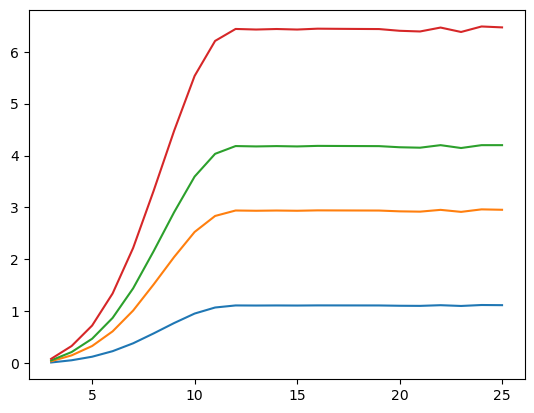

In [104]:
import matplotlib.pylab as plt


for i in [t_1, t_2, t_3, t_4]:
    print(list(i.values()))
    x = list(i.keys())
    y = np.array(list(i.values()))
    plt.plot(x, y)
plt.show()

In [114]:
test = gdf_in.copy()
res = test.sort_values(by=["ws_150"])[::-1]
# k = 2.686965394630808
# A = 10.703942994264505

In [120]:
res["ws_150"]

9.511642009282824

In [123]:
res["wb_A_150"][:int(len(test) * 0.1)].mean()
#res["wb_k_150"][:int(len(test) * 0.1)].mean()

10.703846243522268

# Test SOME STUFF BELOW

In [6]:
pa_gdf = gpd.read_file(f'{paths["gwa_placement_area"]}', crs=param["epsg_general"])

In [25]:
pa_gdf.columns

Index(['ad_100', 'ad_150', 'ad_200', 'ad_50', 'iec1', 'iec2', 'iec3', 'ws_100',
       'ws_150', 'ws_200', 'ws_50', 'geometry', 'imp_500m', 'imp_750m',
       'imp_1000m', 'imp_1250m', 'imp_1500m', 'imp_1750m', 'imp_2000m',
       'imp_2250m', 'imp_2500m', 'imp_2750m', 'imp_3000m', 'imp_3250m',
       'imp_3500m', 'imp_3750m', 'imp_4000m', 'imp_4250m', 'imp_4500m',
       'imp_4750m', 'imp_5000m', 'imp_5250m', 'imp_5500m', 'imp_5750m',
       'imp_6000m'],
      dtype='object')

In [26]:
def buffer_geoms(gdf_in, buffer, proj_epsg=25832):
    '''
    Function calculates a buffered GeoSeries from the geometry column of a geopandas DataFrame
    in a given meter based coordinate reference system (crs) and converts it back to the orginial crs
    '''
    init_crs = gdf_in.crs
    gdf_in = gdf_in.to_crs(proj_epsg)
    buffered = gpd.GeoDataFrame(geometry = gdf_in.geometry.buffer(buffer)).to_crs(init_crs)

    return buffered

def add_house_impact_allocation(param_dict, paths_dict):
    '''
    Function calculates for a given set of impact zones (in meter) the number of affected houses per impact zone for each
    cell in a given raster.

    Parameters
    ----------
        param_dict : dict
            parameter dictionary specified in the config.py file
        paths_dict : dict
            paths dictionary specified in the config.py file

    Returns
    -------
        None
    '''
    osmfiles = glob.glob(os.path.join(paths_dict["osm_path"], '*.zip'))
    filename = paths_dict["osm_file_names"]["buildings"]
    #sub_files = np.array_split(osmfiles, 6)

    # # Read in shapefile with house prices:
    # hp_gdf = gpd.read_file(f'{paths_dict["house_prices"]}', crs=param_dict["epsg_general"])
    # hp_gdf.loc[:, 'state'].replace({'-':'_', 'ü': 'ue', 'ä': 'ae', 'ö': 'oe'}, regex=True, inplace=True)
    # hp_gdf.rename(columns={'avg_house_': 'hp', 'sqm_euro_v':'sqm_p', 'avg_apartm':'ap_size','no_appartm':'no_ap'}, inplace=True)

    # Calculate number of affected houses per impact zone for each raster cell
    print('Started calculating impact allocation')
    start = time.process_time() # start time check for calculations
    pa_gdf = gpd.read_file(f'{paths_dict["gwa_placement_area"]}', crs=param_dict["epsg_general"])
    col_len = len(pa_gdf.columns)

    for buff in param_dict["impact_buffers"]:
        print(f'Calculating {buff}m impacts...')
        pa_buff = buffer_geoms(pa_gdf, buff , param_dict["epsg_distance_calc"])

        inter_list = []
        for z in osmfiles:
            # osm_list = []
            # for file in z:
            #print(f"Reading buildings data from {z}/{filename}")
            osm_gdf = gpd.read_file(f"zip://{z}/{filename}").loc[:,['geometry']].to_crs(param_dict["epsg_distance_calc"])
            osm_gdf = osm_gdf.set_geometry(osm_gdf.centroid).to_crs(param_dict["epsg_general"])
            #osm_list.append(osm_gdf)

            # Only consider residential areas
            gdf_res = gpd.read_file(f"zip://{z}/{paths_dict['osm_file_names']['landuse']}").loc[:, ['fclass','geometry']]
            gdf_res = gdf_res.loc[(gdf_res['fclass'] == 'residential')]
            osm_gdf = gpd.clip(osm_gdf, gdf_res)

            #reg_gdf = pd.concat(osm_list)
            #dfsjoin = gpd.sjoin(pa_buff, reg_gdf, how="left") #Spatial join Points to polygons
            dfsjoin = gpd.sjoin(pa_buff, osm_gdf, how="left") #Spatial join Points to polygons
            counts = dfsjoin.groupby(dfsjoin.index)["index_right"].count().to_numpy()

            inter_list.append(counts) # add np.array of intersection count for file z to a list
        

        inter_vector = np.sum(inter_list, axis=0) # combine array list first to a single array and then sum over the relevant array column
        pa_gdf[f'imp_{buff}m'] = inter_vector # Add impact to output GeoDataFrame
        print(f"Finished {buff}m impact zone. Time passed:", time.process_time() - start)

    # Correct impact double-counting:
    # To avoid double counting of impacts subtract the larger buffer zone by the next smaller one
    # The smallest buffer zone impact count will simply be subtracted by 0 
    impacts_dc = pa_gdf.iloc[:, col_len:].copy().to_numpy()
    sub_array= np.hstack((np.zeros((impacts_dc.shape[0],1)), impacts_dc[:, :-1])) # adds zero column to numpy array in position 0
    corrected_impacts = impacts_dc - sub_array
    pa_gdf.iloc[:, col_len:] = corrected_impacts.astype(int)

    # # Add house price information to each cell
    # print('Adding house price information')
    # joined_gdf = gpd.sjoin(pa_gdf, hp_gdf, how="inner", op="intersects")
    # joined_gdf.drop(columns=['index_right'], inplace=True)
    # joined_gdf = joined_gdf[~joined_gdf.index.duplicated(keep="first")] # drop duplicates keep first

    # Save file:
    # joined_gdf.to_file(f'{paths_dict["optimization_file"]}', index=True)
    pa_gdf.to_file(f'{paths_dict["optimization_file"]}', index=True)
    print('Finished generating impact allocation')

    return None

def add_house_price_info(param_dict, paths_dict):
    """
    Function adds house price information to optimization GeoDataFrame (ogdf) based on an inner spatial
    join with the ogdf rows (Expl.: Information is added to row if geometry of the ogdf is inside of the house price
    region of the house price gdf)

    Parameters
    ----------
        param_dict : dict
            parameter dictionary specified in the config.py file
        paths_dict : dict
            paths dictionary specified in the config.py file
    """
    # Read in shapefile with house prices:
    hp_gdf = gpd.read_file(f'{paths_dict["house_prices"]}', crs=param_dict["epsg_general"])
    hp_gdf.loc[:, 'state'].replace({'-':'_', 'ü': 'ue', 'ä': 'ae', 'ö': 'oe'}, regex=True, inplace=True)
    hp_gdf.rename(columns={'avg_house_': 'hp', 'sqm_euro_v':'sqm_p', 'avg_apartm':'ap_size','no_appartm':'no_ap'}, inplace=True)

    # Read in shapefile with turbine locations:
    pa_gdf = gpd.read_file(f'{paths_dict["optimization_file"]}', crs=param_dict["epsg_general"])

    # Add house price information to each raster cell
    print('Adding house price information')
    joined_gdf = gpd.sjoin(pa_gdf, hp_gdf, how="inner", op="intersects")
    joined_gdf.drop(columns=['index_right'], inplace=True)
    joined_gdf = joined_gdf[~joined_gdf.index.duplicated(keep="first")] # drop duplicates keep first

    # Save file:
    joined_gdf.to_file(f'{paths_dict["optimization_file"]}', index=True)
    print("Final Number of cells:", len(joined_gdf))

In [8]:
for buff in param["impact_buffers"]:
    pa_gdf[f'imp_{buff}m'] = 3000 # Add impact to output GeoDataFrame

In [23]:
param["impact_buffers"] = [500]

In [24]:
add_house_impact_allocation(param, paths)

Started calculating impact allocation
Calculating 500m impacts...
Finished 500m impact zone. Time passed: 2065.953125
Finished generating impact allocation


In [27]:
add_house_price_info(param, paths)

Adding house price information
Final Number of cells: 518702


In [10]:
pa_gdf.to_file(f'test.shp', index=True)


In [28]:
res = gpd.read_file(f'{paths["optimization_file"]}', crs=param["epsg_general"])

In [29]:
res.columns

Index(['level_0', 'index', 'ad_100', 'ad_150', 'ad_200', 'ad_50', 'iec1',
       'iec2', 'iec3', 'ws_100', 'ws_150', 'ws_200', 'ws_50', 'imp_500m',
       'county', 'CC_2', 'pop_count', 'pop_d_km2', 'state', 'sqm_p', 'ap_size',
       'no_ap', 'hp', 'geometry'],
      dtype='object')

In [30]:
import fiona

In [31]:
fiona.supported_drivers  

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}

In [159]:
wind_power_function(3, 115/2, 1.225, 1) *1000 * 

9.085264998806013

In [165]:
res = 0
for i in range(1,25):
    res += weibull_wind_pdf(i, 2, 6)

In [181]:
weibull_wind_pdf(16, 2, 6)

0.0007253225200641318

In [182]:
(0.0016087117801897577 + 0.0007253225200641318)/2

0.0011670171501269447